# Setup

In [1]:
!python --version

Python 3.8.13


In [2]:
!nvidia-smi

Sun Nov 20 13:31:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.43       Driver Version: 456.43       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  TCC  | 00000001:00:00.0 Off |                  Off |
| N/A   30C    P0    25W / 250W |      1MiB / 16258MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [1]:
import os
os.environ["PYTHONHASHSEED"] = str(42)
import sys
sys.path.append("C:\\Miniconda\\envs\\kogas_env1\\Lib\\site-packages")
import shutil
import datetime
import random as rnd
from glob import glob
import gc
import optuna
from optuna import Trial, create_study
from optuna.samplers import TPESampler
import pickle
import copy

import numpy as np
from numpy import random as np_rnd
import pandas as pd
from scipy.stats import linregress
from scipy.stats import trim_mean

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn import metrics as skl_merics
from sklearn.decomposition import PCA

import sklearn as skl
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import ExtraTreeRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore")

pd.set_option("display.max_rows", 50)

plt.rcParams["axes.unicode_minus"] = False
font_path = "C:\\Users\\kogas\\Desktop\\nanum-square\\NanumSquareR.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [2]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    rnd.seed(seed)
    np_rnd.seed(seed)

def diff(x1, x2):
    x2 = set(x2)
    return [i for i in x1 if i not in x2]

def softmax(x, multiplier=2.0):
    x = x * multiplier
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def pickleIO(obj, src, mode="r"):
    if mode == "w":
        with open(src, "wb") as f:
            pickle.dump(obj, f)
        return 0
    else:
        with open(src, "rb") as f:
            obj = pickle.load(f)
        return obj
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

In [3]:
class CFG:
    debug = False
    train_timesteps = 60
    test_timesteps = 168
    pca_threshold = 0.9
    n_folds = 5
    
    quarter_dic = {
    "Q1": [1, 2, 3],
    "Q2": [4, 5, 6],
    "Q3": [7, 8, 9],
    "Q4": [10, 11, 12],
    }
    # df_indust 에는 쿼터가 없기 때문에, 다른 데이터에 쿼터를 달아준다
    month_dic = {
        1 : 'Q1',
        2 : 'Q1',
        3 : 'Q1',
        4 : 'Q2',
        5 : 'Q2',
        6 : 'Q2',
        7 : 'Q3',
        8 : 'Q3',
        9 : 'Q3',
        10 : 'Q4',
        11 : 'Q4',
        12 : 'Q4'
    }

In [4]:
folder_path = "C:\\Users\\kogas\\Desktop\\jupyter_root_folder\\YJ_notebooks\\"
# C:\Users\kogas\Desktop\jupyter_root_folder\YJ_notebooks
seed_everything()

In [5]:
target_vars = ["target_civil", "target_ind"]
nontrain_vars = ["year"]
bin_vars = []
cat_vars = ["quarter", "month"]

## Inference

In [6]:
feature_version = 3

architecture_name = "fv" + str(feature_version) + "_projection_noTF_vanillaTimeFE_5folds_" + "linear_standard" + "_try1"
architecture_root_path = folder_path + "architectures\\" + architecture_name + "\\"

assert os.path.exists(architecture_root_path)

model_name_list = pickleIO(None,  architecture_root_path + "model_name_list.pkl", "r")

feature_type_dic = pickleIO(None, architecture_root_path + "feature_type_dic.pkl", "r")
target_vars = feature_type_dic["target_vars"]
target_var = feature_type_dic["target_var"]
nontrain_vars = feature_type_dic["nontrain_vars"]
bin_vars = feature_type_dic["bin_vars"]
cat_vars = feature_type_dic["cat_vars"]
num_vars = feature_type_dic["num_vars"]

In [11]:
feature_type_dic

{'target_vars': ['target_civil', 'target_ind'],
 'target_var': 'target_ind',
 'nontrain_vars': ['year',
  'weight_civil',
  'relative_price',
  'gas_price',
  'oil_price'],
 'bin_vars': [],
 'cat_vars': ['quarter', 'month', 'season'],
 'num_vars': ['target_civil',
  'qva',
  '서울_최고기온',
  '부산_평균습도',
  'korea_pop',
  'gdp',
  'year_sin',
  'year_cos',
  'year_linear']}

In [7]:
df_test = pickleIO(None, architecture_root_path + "df_test.pkl", "r")
df_test_x = df_test

In [8]:
df_test_x = df_test_x.drop(nontrain_vars, axis=1)

In [9]:
ohe = pickleIO(None, architecture_root_path + "cat_ohe.pkl", "r")

cat_oh_vars = []
for idx, value in enumerate(cat_vars):
    cat_oh_vars += [value + "_" + str(j) for j in ohe.categories_[idx]]

df_test_x = pd.concat([df_test_x.drop(cat_vars, axis=1), pd.DataFrame(ohe.transform(df_test_x[cat_vars]), columns=cat_oh_vars)], axis=1)
pickleIO(ohe, architecture_root_path + "cat_ohe.pkl", "w")

0

In [13]:
df_test_x.columns

Index(['target_civil', 'qva', '서울_최고기온', '부산_평균습도', 'korea_pop', 'gdp',
       'year_sin', 'year_cos', 'year_linear', 'quarter_Q1', 'quarter_Q2',
       'quarter_Q3', 'quarter_Q4', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'season_0', 'season_1', 'season_2', 'season_3'],
      dtype='object')

In [12]:
df_test_x

,target_civil,qva,서울_최고기온,부산_평균습도,korea_pop,gdp,year_sin,year_cos,year_linear,quarter_Q1,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,2.184680e+06,42446.777886,1.956452,44.846129,51828.416667,184885.416782,0.502912,0.864338,0.083333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.820133e+06,42446.777886,5.059433,49.865542,51820.833333,184885.416782,0.846109,0.533010,0.166667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.497793e+06,42446.777886,11.844516,55.192903,51813.250000,184885.416782,0.999583,0.028864,0.250000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9.561161e+05,42822.158490,17.996333,59.855000,51805.666667,184885.416782,0.883640,-0.468167,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.917982e+05,42822.158490,24.521290,65.597419,51798.083333,184885.416782,0.522939,-0.852370,0.416667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,4.627725e+05,56542.251206,30.768387,76.255806,50971.666667,231892.166667,-0.857163,-0.515045,0.666667,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
164,4.780701e+05,56542.251206,26.659000,72.548333,50965.750000,231892.166667,-0.999688,-0.024974,0.750000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
165,7.933635e+05,56863.963656,20.743323,62.437742,50959.833333,231892.166667,-0.873568,0.486701,0.833333,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
166,1.514058e+06,56863.963656,12.210000,57.043667,50953.916667,231892.166667,-0.519618,0.854399,0.916667,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Inference

In [19]:
def do_fold_inference(fold, TF=True, apply_pca=False, tuning=False):

    model = pickleIO(None, architecture_root_path + "model\\" + model_name + "_fold" + str(fold) + ".pkl", "r")
    scaler = pickleIO(None, architecture_root_path + "scaler\\" + model_name + "_fold" + str(fold) + ".pkl", "r")
    
    df_test_ft = df_test_x.copy()

    if apply_pca:
        pca = PCA(16)
        train_x = df_full_x.iloc[train_idx].reset_index(drop=True)
        pca.fit(scaler.fit_transform(train_x[num_vars]))
        n_comp = np.where(pca.explained_variance_ratio_.cumsum() > CFG.pca_threshold)[0][0] + 1
        print(train_x.columns, n_comp)
        train_x = pd.concat([
            train_x.drop(num_vars, axis=1).reset_index(drop=True),
            pd.DataFrame(pca.transform(scaler.transform(train_x[num_vars]))[:, :n_comp]).reset_index(drop=True)
        ], axis=1)
    else:
        df_test_ft[num_vars] = scaler.transform(df_test_ft[num_vars]) if scaler is not None else df_test_ft
        print(df_test_ft.columns)
        df_test_ft.head()
    test_pred[:, 0] += model.predict(df_test_ft) / CFG.n_folds
   

In [20]:
ntrees = 100 if CFG.debug else 5000
eta = 5e-3

TF = False
tuning = True
correct_overshoot = False

model_output_dic = dict.fromkeys(model_name_list)

for model_name in model_name_list:
    seed_everything()

    test_pred = np.zeros(shape=(len(df_test_x), 1))
    
    for fold in range(CFG.n_folds):
        do_fold_inference(fold, TF=TF, apply_pca=False, tuning=tuning)
        gc.collect()
    
    model_output_dic[model_name] = {
        "test_pred": test_pred,
    }

Index(['target_civil', 'qva', '서울_최고기온', '부산_평균습도', 'korea_pop', 'gdp',
       'year_sin', 'year_cos', 'year_linear', 'quarter_Q1', 'quarter_Q2',
       'quarter_Q3', 'quarter_Q4', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'season_0', 'season_1', 'season_2', 'season_3'],
      dtype='object')
Index(['target_civil', 'qva', '서울_최고기온', '부산_평균습도', 'korea_pop', 'gdp',
       'year_sin', 'year_cos', 'year_linear', 'quarter_Q1', 'quarter_Q2',
       'quarter_Q3', 'quarter_Q4', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'season_0', 'season_1', 'season_2', 'season_3'],
      dtype='object')
Index(['target_civil', 'qva', '서울_최고기온', '부산_평균습도', 'korea_pop', 'gdp',
       'year_sin', 'year_cos', 'year_linear', 'quarter_Q1', 'quarter_Q2',
       'quarter_Q3', 'quarter_Q4', 'month_1', 'month

## Load score weight & ensemble prediction

In [21]:
# ensemble_weight = softmax(1 / score_table["MAPE"].iloc[:len(model_name_list)], multiplier=1 / 1.5)
# ensemble_weight = (1 / score_table["MAPE"].iloc[:len(model_name_list)]) / np.sum(1 / score_table["MAPE"].iloc[:len(model_name_list)])
ensemble_weight= pickleIO(None, architecture_root_path + "ensemble_weight.pkl", "r")

display(ensemble_weight)

ensemble_test_pred = np.stack([model_output_dic[i]["test_pred"] * ensemble_weight.loc[i] for i in model_output_dic.keys()]).sum(axis=0)
# last_ensemble_test_pred = ensemble_test_pred[-1]

ensemble_test_pred = ensemble_test_pred.flatten()

Linear    1.0
Name: MAPE, dtype: float64

In [24]:
ensemble_weight

Linear    1.0
Name: MAPE, dtype: float64

<AxesSubplot: >

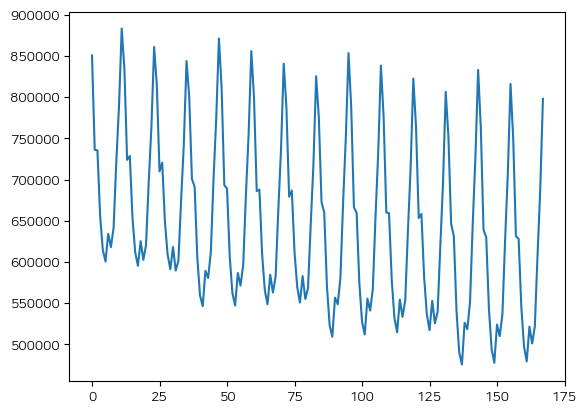

In [25]:
sns.lineplot(ensemble_test_pred)

In [16]:
if correct_overshoot:
    # correct overshoting
    threshold_pct_change = 0.2

    tmp = pd.Series(ensemble_test_pred)
    for idx, value in enumerate(tmp.pct_change().abs() > threshold_pct_change):
        if value:
            max_pct_change = (tmp.iloc[idx] / np.abs(tmp.iloc[idx])) * (threshold_pct_change) 
            tmp.iloc[idx] = tmp.iloc[idx-1] * (1+max_pct_change)
    ensemble_test_pred = tmp

In [17]:
ensemble_test_pred[:5]

array([850761.37622656, 736126.19706876, 735612.86112541, 656075.36034432,
       614598.53948115])

## Submission

In [18]:
df_submission = pd.read_csv(folder_path + 'dataset\\submission_sample.csv')
df_submission.head()
df_submission["IND"] = ensemble_test_pred
df_submission["CIVIL"] = pd.read_csv(folder_path + 'architectures\\civil\\ma_by_month.csv')["CIVIL"]
df_submission.to_csv(architecture_root_path + architecture_name + "_test_inference.csv", index=False)

In [19]:
df_submission.head()

,YEAR,MONTH,CIVIL,IND
0,2021,1,2.010047e+06,850761.376227
1,2021,2,1.714023e+06,736126.197069
2,2021,3,1.272162e+06,735612.861125
3,2021,4,8.830733e+05,656075.360344
4,2021,5,5.485490e+05,614598.539481


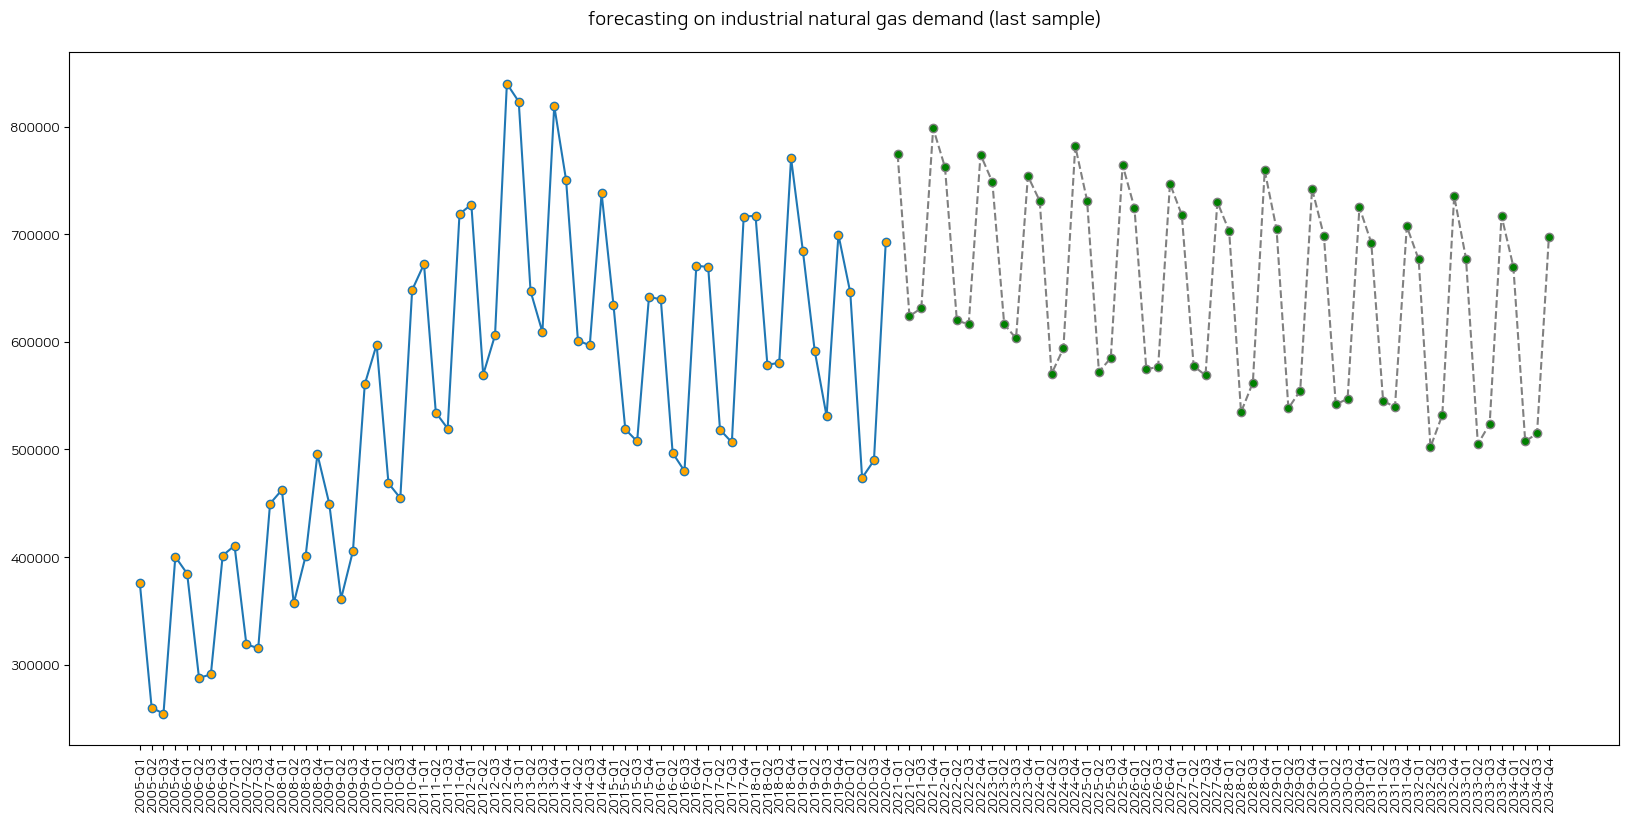

In [20]:
df_eda = pickleIO(None, architecture_root_path + "df_full.pkl", "r")

df_result_viz = df_submission.copy()
df_result_viz.columns = df_result_viz.columns.str.lower()
df_result_viz["quarter"] = df_result_viz["month"].apply(lambda x: CFG.month_dic[x])
df_result_viz

plt.figure(figsize=(20, 9))
plt.plot(
    [str(i[0]) + "-" + str(i[1]) for i in df_eda.loc[df_eda["year"] >= 2005].groupby(["year", "quarter"]).mean().index.values],
    df_eda.loc[df_eda["year"] >= 2005].groupby(["year", "quarter"]).mean()["target_ind"].values,
    marker="o", mfc="orange"
)
plt.plot(
    [str(i[0]) + "-" + str(i[1]) for i in df_result_viz.groupby(["year", "quarter"]).mean().index.values],
    df_result_viz.groupby(["year", "quarter"]).mean()["ind"].values,
    color="grey", linestyle="--", marker="o", mfc="green"
)
plt.title("forecasting on industrial natural gas demand (last sample)", pad=20, fontsize=14, weight="bold")
plt.xticks(rotation=90)
plt.show()